In [1]:
#Installation of MNE 
!pip install mne

In [2]:
#Importing all necessary packages
import mne
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
import glob

In [3]:
# Setting the path of the datasets
base_path = r"C:\Users\Methuna\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\eeg-during-mental-arithmetic-tasks-1.0.0"


In [4]:
# Function to load EEG data from files, extract raw signals and subject IDs
def load_eeg_data(file_pattern):
    raw_list = [] 
    subjects = [] 
    
    for file in glob.glob(os.path.join(base_path, file_pattern)):
        raw = mne.io.read_raw_edf(file, preload=True)
        raw_list.append(raw)
        
        # Extract subject from the file name
        subject = file.split('/')[-1].split('_')[0]  
        subjects.append(subject)
    return raw_list, subjects

In [5]:
# Loads rest and task data
rest_data, rest_subjects = load_eeg_data("*_1.edf")
task_data, task_subjects = load_eeg_data("*_2.edf")

Extracting EDF parameters from C:\Users\Methuna\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\eeg-during-mental-arithmetic-tasks-1.0.0\Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from C:\Users\Methuna\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\eeg-during-mental-arithmetic-tasks-1.0.0\Subject01_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from C:\Users\Methuna\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\eeg-during-mental-arithmetic-tasks-1.0.0\Subject02_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from C:\Users\Methuna\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\eeg-dur

In [6]:
#prints number of rest state and task state files
print(f"Loaded {len(rest_data)} rest state files and {len(task_data)} task state files.")


Loaded 36 rest state files and 36 task state files.


In [7]:
from scipy import signal

# Function to calculate PSD for a list of EEG recordings
def calculate_psd(raw_list, fmin, fmax):
    psd_list = []
    for raw in raw_list:
        data = raw.get_data()
        sfreq = raw.info['sfreq']

        # Calculating PSD using Welch's method
        freqs, psd = signal.welch(data, fs=sfreq, nperseg=2048)

        idx = np.logical_and(freqs >= fmin, freqs <= fmax)

        psd_list.append(psd[:, idx])

    return np.mean(psd_list, axis=0), freqs[idx]

# Calculating PSD for rest states and task states 
psd_rest, freqs_rest = calculate_psd(rest_data, 1, 100)
psd_task, freqs_task = calculate_psd(task_data, 1, 100)

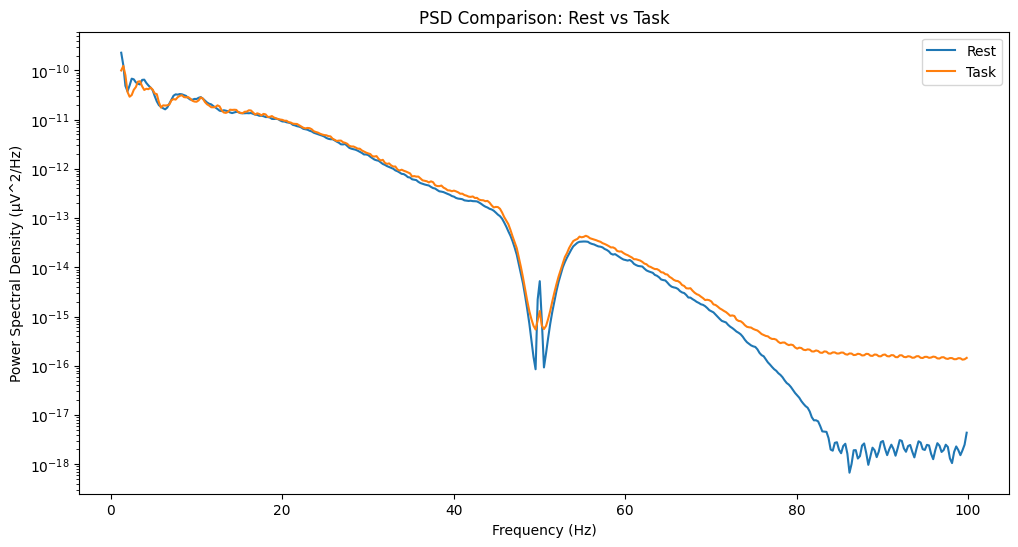

In [8]:
# Plotting PSD for rest and task states
plt.figure(figsize=(12, 6))
plt.semilogy(freqs_rest, psd_rest.mean(axis=0), label='Rest')
plt.semilogy(freqs_task, psd_task.mean(axis=0), label='Task')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (µV^2/Hz)')
plt.legend()
plt.title('PSD Comparison: Rest vs Task')
plt.show()

In [9]:
# Defining frequency bands
bands = {
    'Delta': (1, 4),
    'Theta': (4, 8),
    'Alpha': (8, 12),
    'Beta': (12, 30),
    'Gamma': (30, 100)
}

In [10]:
# Calculation of band power
def calculate_band_power(psd, freqs, fmin, fmax):
    freq_res = freqs[1] - freqs[0]
    idx = np.logical_and(freqs >= fmin, freqs <= fmax)
    return np.sum(psd[:, idx], axis=1) * freq_res

In [11]:
# Calculation of band power for rest and task
rest_powers = {band: calculate_band_power(psd_rest, freqs_rest, fmin, fmax) for band, (fmin, fmax) in bands.items()}
task_powers = {band: calculate_band_power(psd_task, freqs_task, fmin, fmax) for band, (fmin, fmax) in bands.items()}

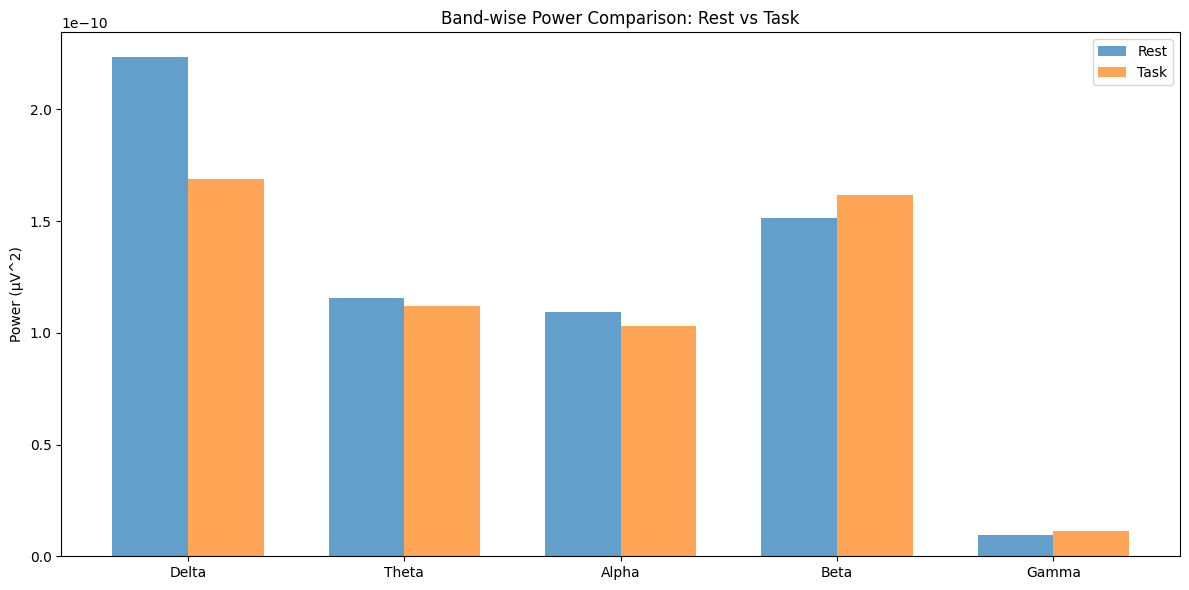

In [12]:
# Plotting band-wise power comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(bands))
width = 0.35

ax.bar(x - width/2, [rest_powers[band].mean() for band in bands], width, label='Rest', alpha=0.7)
ax.bar(x + width/2, [task_powers[band].mean() for band in bands], width, label='Task', alpha=0.7)

ax.set_ylabel('Power (µV^2)')
ax.set_title('Band-wise Power Comparison: Rest vs Task')
ax.set_xticks(x)
ax.set_xticklabels(bands.keys())
ax.legend()

plt.tight_layout()
plt.show()

In [13]:
# Calculating and printing relative changes
print("Relative changes in band power (Task vs Rest):")
for band in bands:
    rel_change = (task_powers[band].mean() - rest_powers[band].mean()) / rest_powers[band].mean() * 100
    print(f"{band}: {rel_change:.2f}%")

Relative changes in band power (Task vs Rest):
Delta: -24.36%
Theta: -2.90%
Alpha: -5.82%
Beta: 6.68%
Gamma: 17.87%


In [14]:
# Combining rest and task data
X = np.vstack([
    np.array([rest_powers[band] for band in bands]).T,
    np.array([task_powers[band] for band in bands]).T
])
y = np.concatenate([np.zeros(len(rest_powers['Delta'])), np.ones(len(task_powers['Delta']))])


In [15]:
# Normalizing the features
X = (X - X.mean(axis=0)) / X.std(axis=0)

In [16]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Data preparation
X_train_tensor = torch.FloatTensor(X_train).unsqueeze(1)  # Adding channel dimension
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test).unsqueeze(1)  # Adding channel dimension
y_test_tensor = torch.LongTensor(y_test)

In [18]:
# Creating DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [19]:
print("X_train shape:", X_train.shape)
print("Sample input shape:", next(iter(train_loader))[0].shape)

X_train shape: (33, 5)
Sample input shape: torch.Size([32, 1, 5])


In [20]:
# EEGNet classification
class EEGNet(nn.Module):
    def __init__(self, input_size, num_classes=2):
        super(EEGNet, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(16)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(32)
        self.fc = nn.Linear(32 * input_size, num_classes)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [21]:
# TSCeption classification
class TSCeption(nn.Module):
    def __init__(self, input_size, num_classes=2):
        super(TSCeption, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(1, 32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(1, 32, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm1d(96)
        self.fc = nn.Linear(96 * input_size, num_classes)

    def forward(self, x):
        x1 = torch.relu(self.conv1(x))
        x2 = torch.relu(self.conv2(x))
        x3 = torch.relu(self.conv3(x))
        x = torch.cat([x1, x2, x3], dim=1)
        x = self.bn(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [22]:
# Initializing models
input_size = X_train.shape[1]
eegnet = EEGNet(input_size)
tsception = TSCeption(input_size)

In [23]:
# Function to train classification model using Adam optimizer and cross-entropy loss
def train_model(model, train_loader, num_epochs=100):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [24]:
# Train models
print("Training EEGNet:")
train_model(eegnet, train_loader)
print("\nTraining TSCeption:")
train_model(tsception, train_loader)

Training EEGNet:
Epoch [10/100], Loss: 0.5698
Epoch [20/100], Loss: 0.6544
Epoch [30/100], Loss: 0.8892
Epoch [40/100], Loss: 0.1617
Epoch [50/100], Loss: 0.4764
Epoch [60/100], Loss: 0.0541
Epoch [70/100], Loss: 0.8168
Epoch [80/100], Loss: 0.3640
Epoch [90/100], Loss: 0.1488
Epoch [100/100], Loss: 0.4885

Training TSCeption:
Epoch [10/100], Loss: 0.0272
Epoch [20/100], Loss: 0.4400
Epoch [30/100], Loss: 0.2360
Epoch [40/100], Loss: 0.3720
Epoch [50/100], Loss: 0.0365
Epoch [60/100], Loss: 0.3963
Epoch [70/100], Loss: 1.6225
Epoch [80/100], Loss: 0.3504
Epoch [90/100], Loss: 0.5651
Epoch [100/100], Loss: 0.9383


In [25]:
# Prediction of EEGNet Model and TSCeption Model
def check_predictions(model, X_test):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs.data, 1)

    unique, counts = np.unique(predicted.numpy(), return_counts=True)
    print("Prediction distribution:", dict(zip(unique, counts)))

print("EEGNet Predictions:")
check_predictions(eegnet, X_test_tensor)

print("\nTSCeption Predictions:")
check_predictions(tsception, X_test_tensor)

EEGNet Predictions:
Prediction distribution: {0: 2, 1: 7}

TSCeption Predictions:
Prediction distribution: {0: 3, 1: 6}


In [26]:
# Evaluating Model Performance
def evaluate_model(model, X_test, y_test, subjects, class_labels=["rest", "task"]):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs.data, 1)

    y_true = y_test.numpy()
    y_pred = predicted.numpy()

    # Printing predicted labels with subject information
    print("Predicted Labels:")
    for i, pred in enumerate(y_pred):
        print(f"Subject: {subjects[i]}, Predicted State: {class_labels[pred]}")

    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    accuracy = accuracy_score(y_true, y_pred)



    # Handling the case where precision, recall, and f1 are undefined
    if len(np.unique(y_pred)) == 1:
        if np.unique(y_pred)[0] == 0:
            precision = 0
            recall = 0
        else:
            precision = 1
            recall = cm[1,1] / (cm[1,0] + cm[1,1])
        f1 = 0 if precision + recall == 0 else 2 * (precision * recall) / (precision + recall)
    else:
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

In [27]:
print("EEGNet Results:")
test_indices = range(len(X_test))  # Assuming the test data is in the same order as the loaded data
test_subjects = rest_subjects[:len(X_test)] + task_subjects[:len(X_test)]  # Combine rest and task subjects
evaluate_model(eegnet, X_test_tensor, y_test_tensor, [test_subjects[i] for i in test_indices], class_labels=["rest", "task"])

print("\nTSCeption Results:")
evaluate_model(tsception, X_test_tensor, y_test_tensor, [test_subjects[i] for i in test_indices], class_labels=["rest", "task"])

EEGNet Results:
Predicted Labels:
Subject: C:\Users\Methuna\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\eeg-during-mental-arithmetic-tasks-1.0.0\Subject00, Predicted State: task
Subject: C:\Users\Methuna\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\eeg-during-mental-arithmetic-tasks-1.0.0\Subject01, Predicted State: rest
Subject: C:\Users\Methuna\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\eeg-during-mental-arithmetic-tasks-1.0.0\Subject02, Predicted State: task
Subject: C:\Users\Methuna\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\eeg-during-mental-arithmetic-tasks-1.0.0\Subject03, Predicted State: task
Subject: C:\Users\Methuna\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\eeg-during-mental-arithmetic-tasks-1.0.0\Subject04, Predicted State: task
Subject: C:\Users\Methuna\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\eeg-during-mental-arithmetic-tasks-1.0.0\Subject05, Predicted State: rest
Subject: C:\Users\Methuna\Downloads\eeg-during-mental-arithm